In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

In [2]:
df = pd.read_csv("/content/card_transdata.csv")

In [3]:
df.head(3)

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0


In [4]:
df.isnull().sum()

,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,0
used_chip,0
used_pin_number,0
online_order,0
fraud,0


In [5]:
df.duplicated().sum()

0

In [6]:
df.dtypes

,0
distance_from_home,float64
distance_from_last_transaction,float64
ratio_to_median_purchase_price,float64
repeat_retailer,float64
used_chip,float64
used_pin_number,float64
online_order,float64
fraud,float64


In [7]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
zero_counts=df.eq(0).sum()
zero_counts

,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,118464
used_chip,649601
used_pin_number,899392
online_order,349448
fraud,912597


In [9]:
len(df)

1000000

In [10]:
# Proportion of zeros
zero_proportion = zero_counts / len(df)
print("\nProportion of Zeros:\n", zero_proportion)


Proportion of Zeros:
 distance_from_home                0.000000
distance_from_last_transaction    0.000000
ratio_to_median_purchase_price    0.000000
repeat_retailer                   0.118464
used_chip                         0.649601
used_pin_number                   0.899392
online_order                      0.349448
fraud                             0.912597
dtype: float64


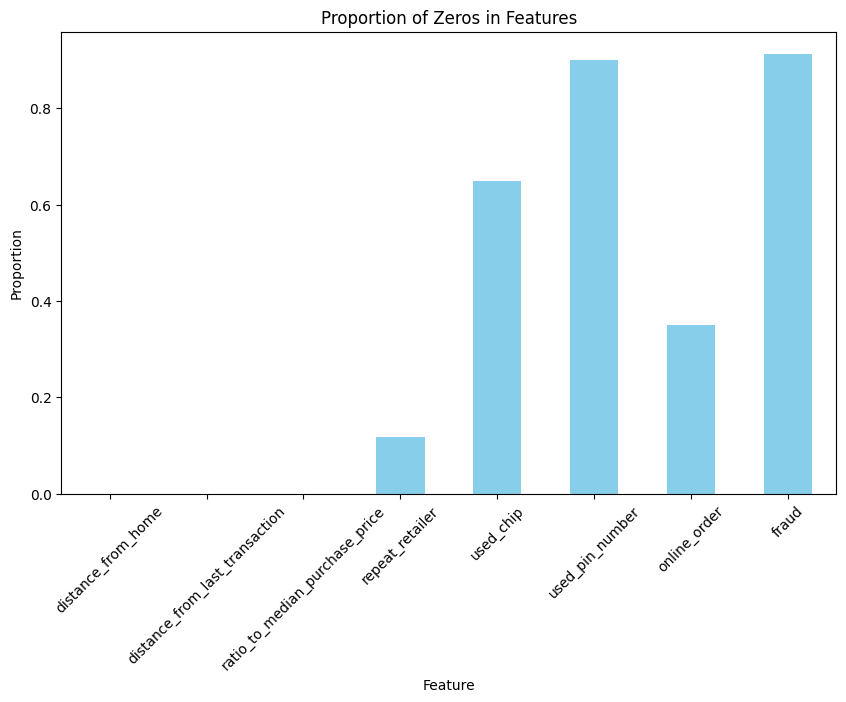

In [11]:
# Visualize zero proportions
plt.figure(figsize=(10, 6))
zero_proportion.plot(kind='bar', color='skyblue')
plt.title("Proportion of Zeros in Features")
plt.ylabel("Proportion")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.show()

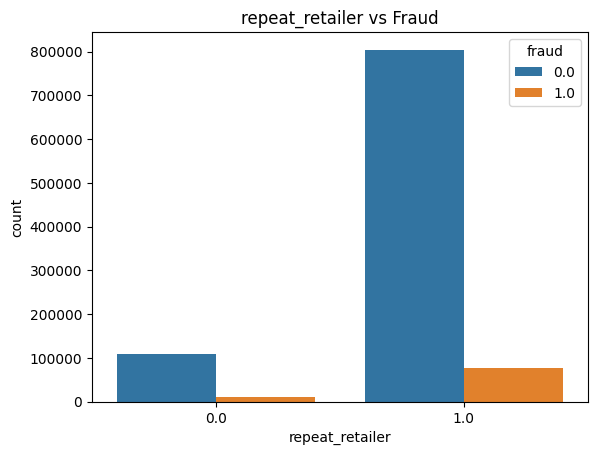

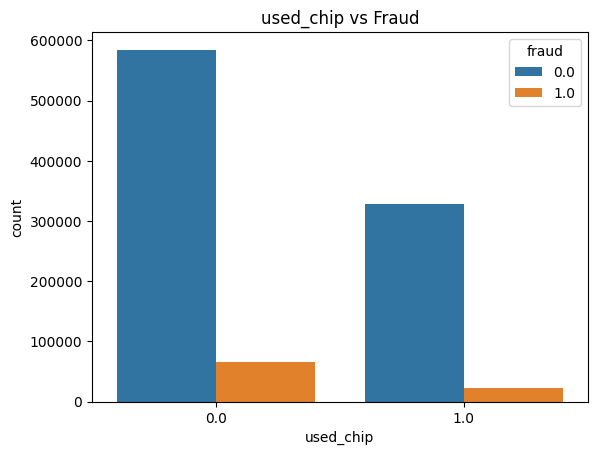

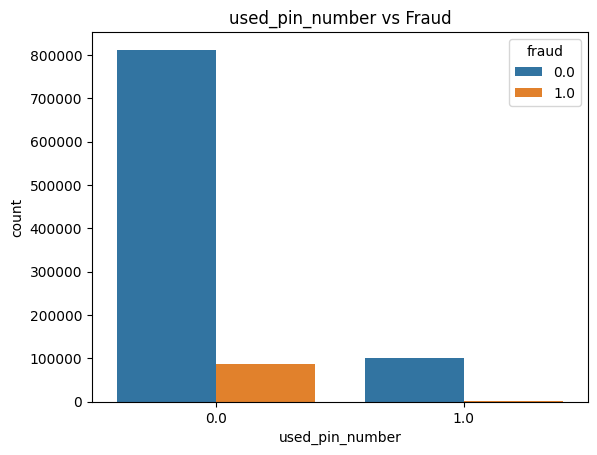

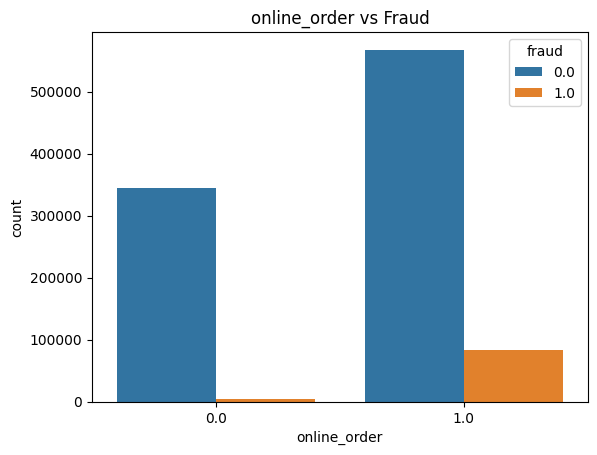

In [12]:
# Investigate the relationship with fraud
for col in ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']:
    sns.countplot(x=col, hue='fraud', data=df)
    plt.title(f"{col} vs Fraud")
    plt.show()

In [13]:
# Check correlation of zero values with the target
for col in ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']:
    zero_corr = df[col].eq(0).astype(int).corr(df['fraud'])
    print(f"Correlation of zero in {col} with fraud: {zero_corr}")

Correlation of zero in repeat_retailer with fraud: 0.0013574501055808466
Correlation of zero in used_chip with fraud: 0.06097459760792185
Correlation of zero in used_pin_number with fraud: 0.10029253729161655
Correlation of zero in online_order with fraud: -0.19197252239629364


1. repeat_retailer
Proportion of Zeros: 11.8%.
Correlation with Fraud: Very low (0.0014).
Action:
The low correlation suggests that this feature's zero values are not strongly predictive of fraud.
Keep this feature as is for now, but monitor its importance during feature selection or model interpretation.

2. used_chip
Proportion of Zeros: 64.96%.
Correlation with Fraud: Moderate (0.061).
Action:
The moderate correlation suggests some predictive power.
Consider retaining the feature as is, but ensure its impact is evaluated during model training (e.g., feature importance analysis).

3. used_pin_number
Proportion of Zeros: 89.94%.
Correlation with Fraud: Significant (0.100).
Action:
The significant correlation and high proportion of zeros make this feature important.
Treat it as a categorical variable (0 = no PIN used, 1 = PIN used).

4. online_order
Proportion of Zeros: 34.94%.
Correlation with Fraud: Significant but negative (-0.192).
Action:
The negative correlation suggests transactions that are not online are less likely to be fraudulent.
Retain this feature but monitor its influence on model performance.

5. Features with No Zeros
distance_from_home, distance_from_last_transaction, ratio_to_median_purchase_price:
These features have no zero values and can be used as is.

6. Imbalanced Target (fraud)
Proportion of Zeros: 91.26%.
Action:
The target is highly imbalanced. Use techniques like SMOTE, undersampling, or class weights during model training.


Why Convert Even if They Are Floats?
Binary Columns Should Conceptually Be Integers:

While the column is technically float64, a binary variable (0.0 or 1.0) conceptually represents discrete categories (e.g., No/Yes or False/True). Converting them to int makes it clearer that they are categorical and not continuous variables.
Readability:

Integer values (0 and 1) are easier to interpret than floats (0.0 and 1.0), especially when debugging or inspecting data.
Avoid Potential Issues in Models or Libraries:

Some libraries or preprocessing steps (e.g., certain encoders or feature selectors) might treat floats as continuous data and apply unnecessary transformations. Converting them to integers ensures they are treated as discrete.
Memory Efficiency:

Converting from float64 to int32 (or even int8 if values range only between 0 and 1) reduces memory usage significantly, which is particularly important for large datasets.


When You Can Skip the Conversion

If you are confident that:
Your machine learning pipeline will handle float64 binary features correctly.
You don't mind the extra memory usage of float64.
You don't need the clarity of binary variables as integers.
In that case, you can skip the conversion step.

What Happens Without Conversion?

If the binary features remain as float64, models like Logistic Regression, Random Forest, etc., will still treat 0.0 and 1.0 as valid binary inputs and train normally. No errors will occur unless specific preprocessing steps require discrete types.

Conclusion

You can skip this step if:

You're okay with float64 as the data type for binary columns.
You understand that the dataset size and memory impact will slightly increase with float64 compared to int.

In [14]:
binary_features = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

In [15]:
binary_features = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']
df[binary_features] = df[binary_features].astype(int)

In [16]:
df.dtypes

,0
distance_from_home,float64
distance_from_last_transaction,float64
ratio_to_median_purchase_price,float64
repeat_retailer,int64
used_chip,int64
used_pin_number,int64
online_order,int64
fraud,float64


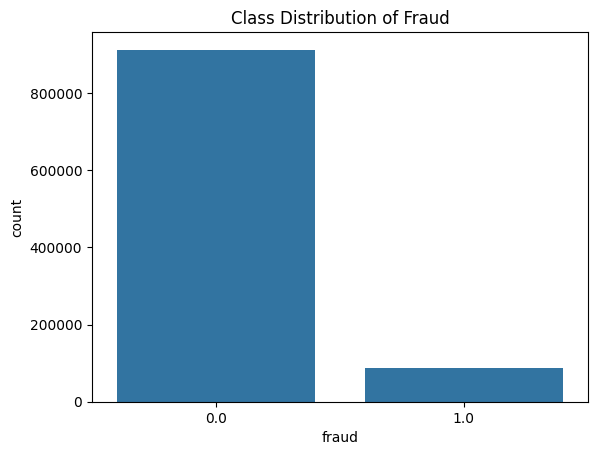

In [17]:
# Class distribution
sns.countplot(x='fraud', data=df)
plt.title("Class Distribution of Fraud")
plt.show()


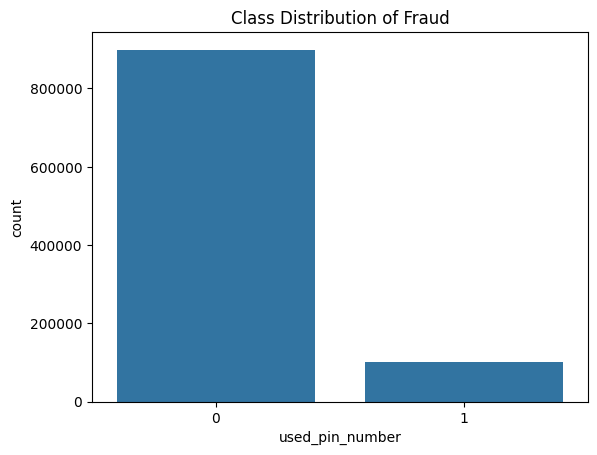

In [18]:
# Class distribution
sns.countplot(x='used_pin_number', data=df)
plt.title("Class Distribution of Fraud")
plt.show()


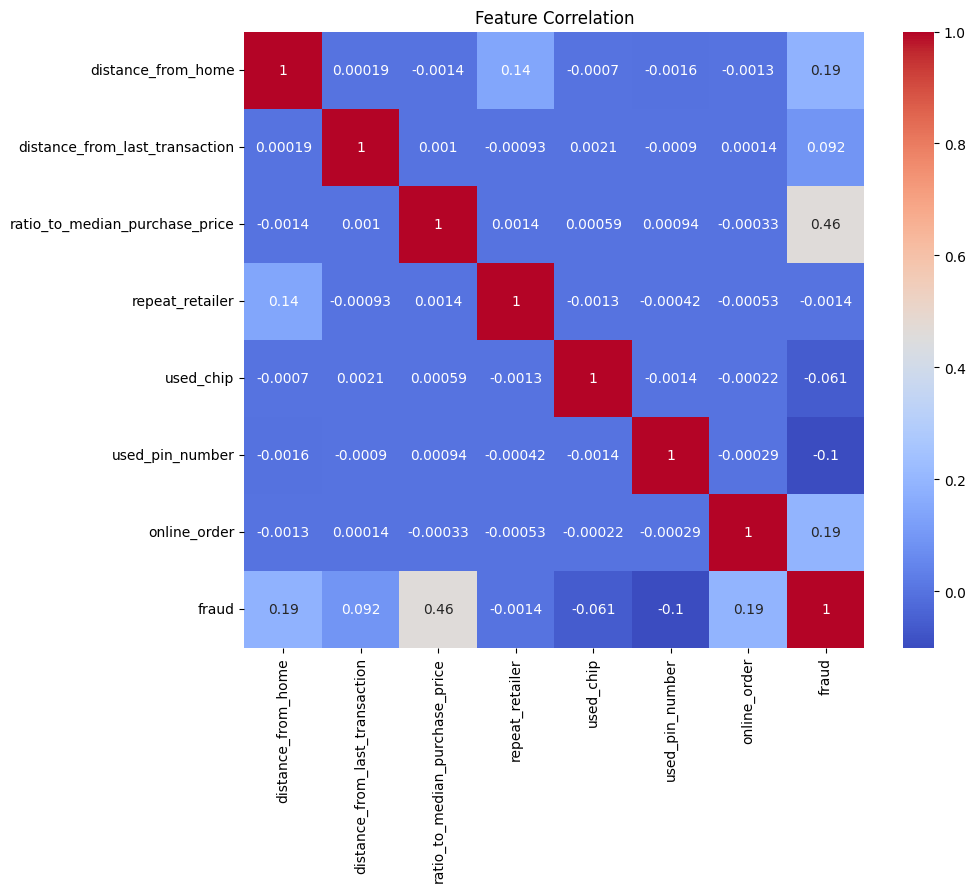

In [19]:
# Correlation heatmap
correlation = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Feature Correlation")
plt.show()

In [20]:
# Check Multicolinearty

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

x = df.drop(columns=['fraud'])

#add_constant(X): Adds a constant term (intercept) to the dataset.
#This is necessary because VIF calculation involves a regression model, and the constant term represents the intercept.

x_with_const = add_constant(x)

vif_data = pd.DataFrame()
vif_data['feature'] = x_with_const.columns

vif_data['VIF'] = [variance_inflation_factor(x_with_const.values, i ) for i in range(x_with_const.shape[1])]



In [21]:
# If the VIF is greater than 10 for a feature, it suggests multicollinearity, which means that feature is highly correlated with other features in the dataset. You might want to remove it or combine it with other features.

vif_data

,feature,VIF
0,const,11.423736
1,distance_from_home,1.020920
2,distance_from_last_transaction,1.000007
3,ratio_to_median_purchase_price,1.000007
4,repeat_retailer,1.020918
5,used_chip,1.000009
6,used_pin_number,1.000006
7,online_order,1.000002


Key Insights:

No Multicollinearity:

The VIF values for all features (except for const) are close to 1, indicating there is no significant multicollinearity between the features.
A VIF greater than 10 typically suggests problematic multicollinearity, but none of your features exceed this threshold.
The Constant Term (const):

The const term has a VIF of 11.42, which is somewhat higher than other features. However, this is expected because the constant is typically correlated with all other features in the model and doesn’t represent any actual feature.
In practice, this value is generally ignored when interpreting VIF, as it does not affect the model’s performance.


Univariate Analysis:

Definition: Univariate analysis is the analysis of a single variable at a time. It involves analyzing the distribution, central tendency (mean, median), spread (variance, standard deviation), and shape of the data (e.g., skewness and kurtosis) for a single feature.
Objective: To understand the characteristics and distribution of each feature independently.

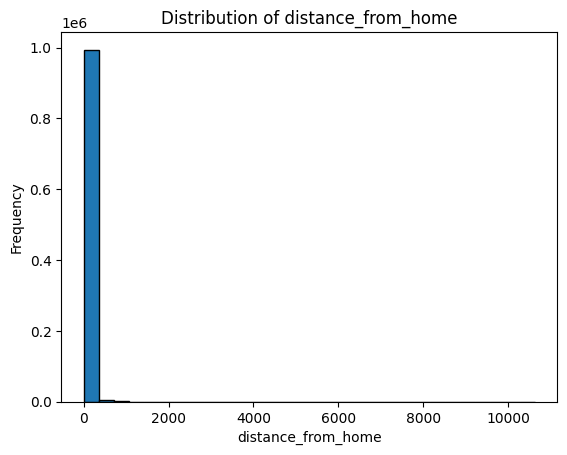

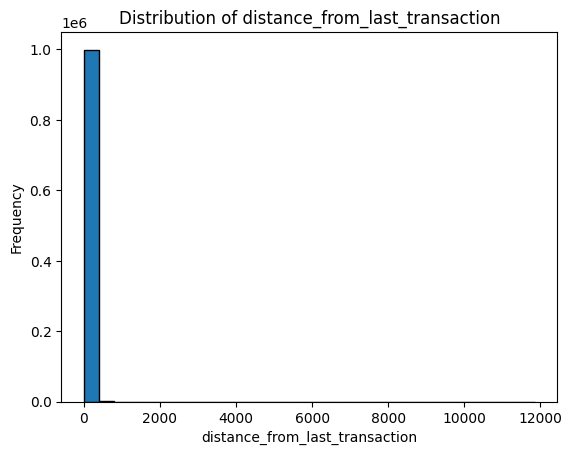

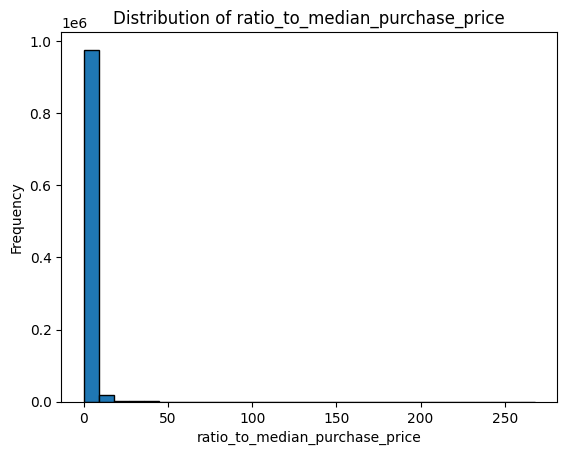

In [22]:
# Univariate analysis for numerical features

numerical_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
for feature in numerical_features:
    plt.hist(df[feature], bins=30, edgecolor='k')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


In [23]:
# Applying BOX-COX Tranformation
numerical_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
#for col in numerical_features:
#    df[col] = np.log1p(df[col])  # log1p = log(x + 1) to avoid issues with 0 values

from scipy.stats import boxcox

for col in numerical_features:
    df[col], _ = boxcox(df[col] + 1e-5)


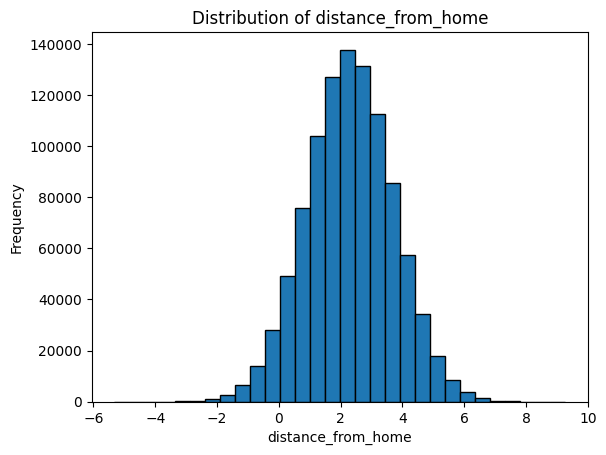

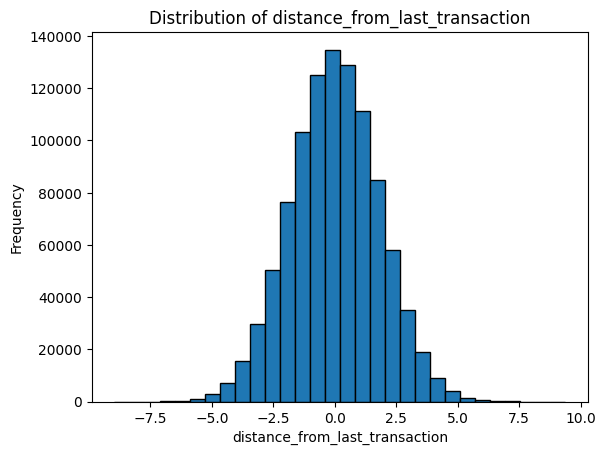

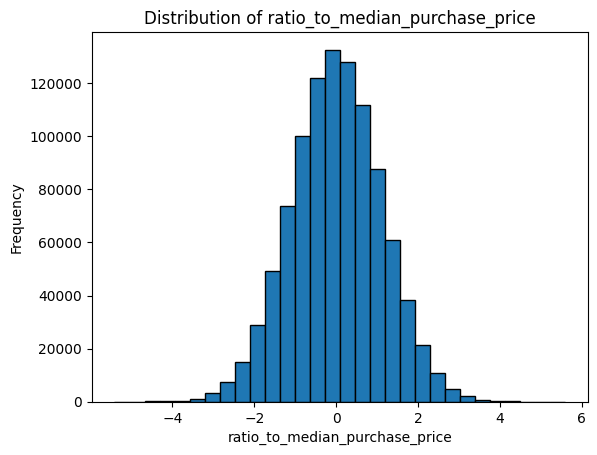

In [24]:

numerical_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
for feature in numerical_features:
    plt.hist(df[feature], bins=30, edgecolor='k')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()


For the categorical features like ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order'], these are likely binary (0 or 1) columns. You do not need to apply transformations like log, Box-Cox, or Yeo-Johnson on such columns because these transformations are designed for continuous data.

Why Transformation Isn't Needed for Categorical Features:
Binary Data (0/1): Transformations like log or Box-Cox are not meaningful for binary data since these techniques assume a continuous range of values. Binary values are already in a form usable by most machine learning algorithms.
Categorical Nature: For such data, you usually focus on encoding (if necessary) or directly using them as they are.
What You Can Do Instead:
Leave Binary Columns As-Is: If they are already in 0/1 format (int), no further transformation is necessary.

Check for Imbalance: If these columns are imbalanced (e.g., too many zeros or ones), you can handle imbalance using oversampling/undersampling techniques.

Standardization (Optional): If you still want these features to be on a standardized scale (e.g., for some algorithms like Logistic Regression or SVM), you can use StandardScaler or MinMaxScaler:



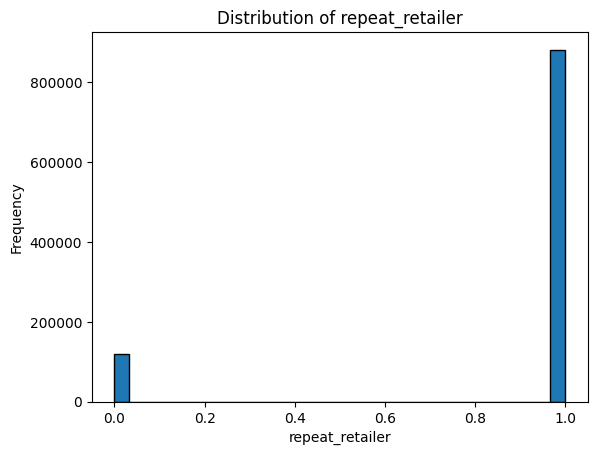

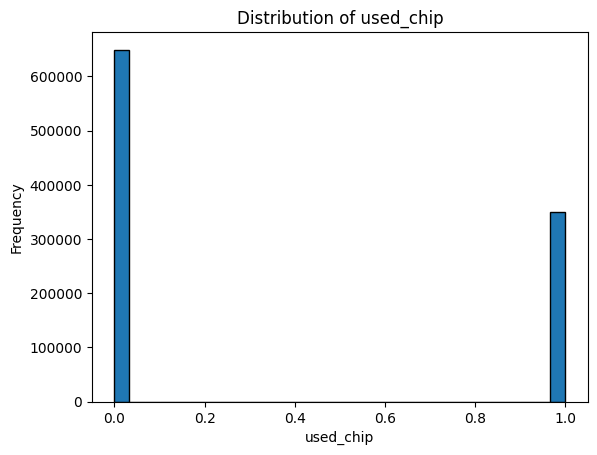

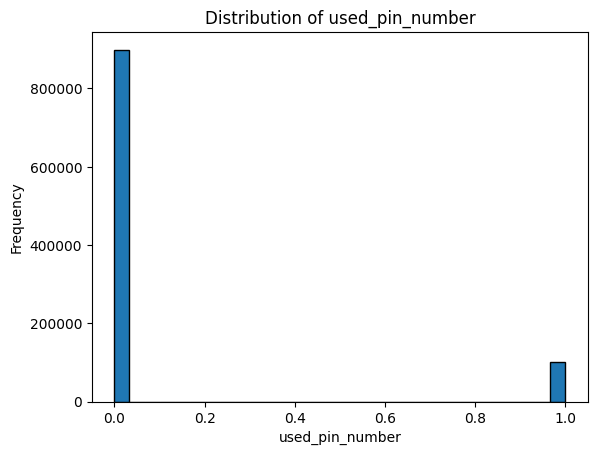

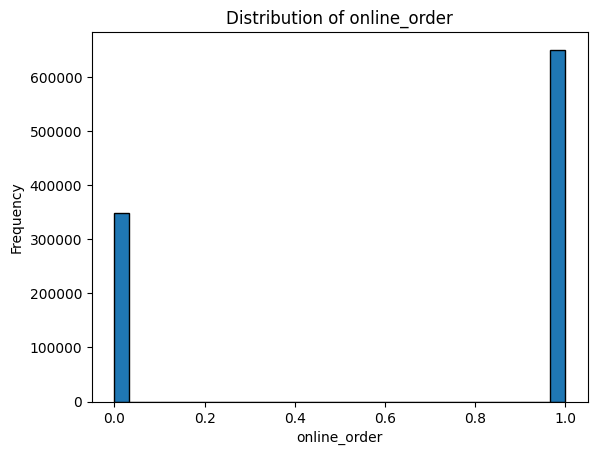

In [25]:
categorical_features = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']

for feature in categorical_features:
    plt.hist(df[feature], bins=30, edgecolor='k')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

Bivariate Analysis:

Definition: Bivariate analysis involves the analysis of two variables to understand the relationship between them. It helps identify correlations, dependencies, or interactions between two features.
Objective: To determine how two variables (one might be categorical and the other numerical) relate to each other.

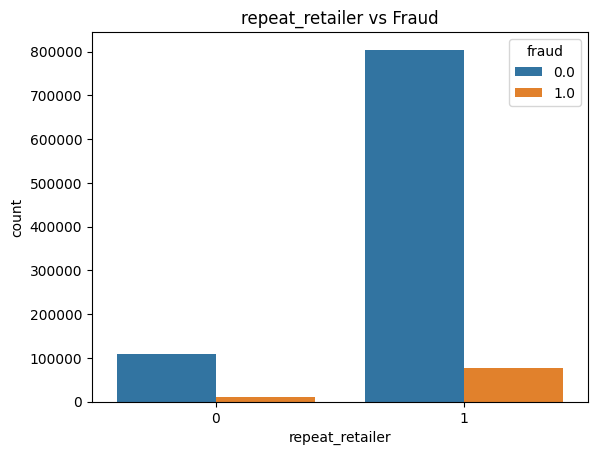

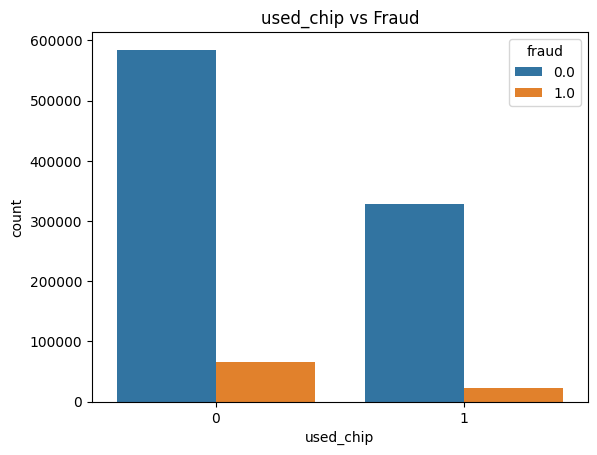

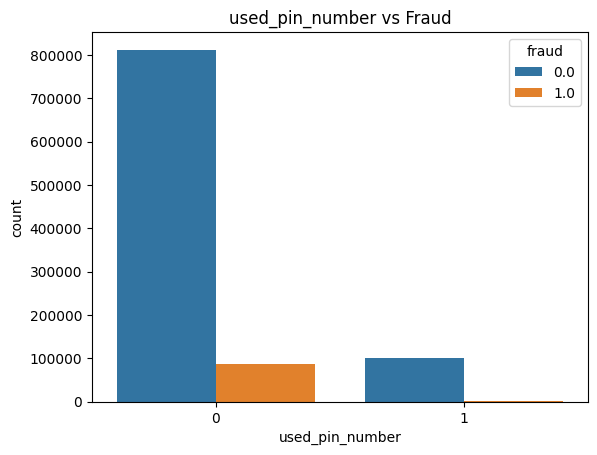

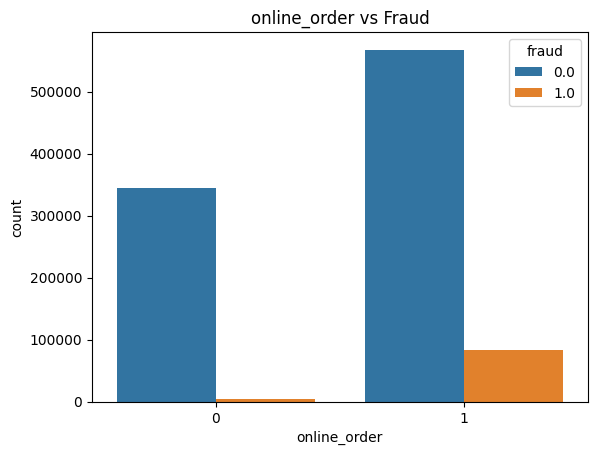

In [26]:
# Bivariate analysis for categorical features
categorical_features = ['repeat_retailer', 'used_chip', 'used_pin_number', 'online_order']
for feature in categorical_features:
    sns.countplot(x=feature, hue='fraud', data=df)
    plt.title(f"{feature} vs Fraud")
    plt.show()


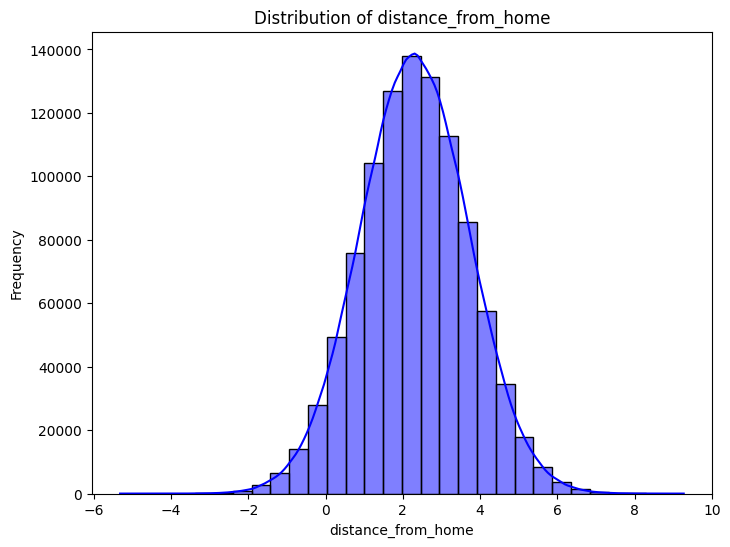

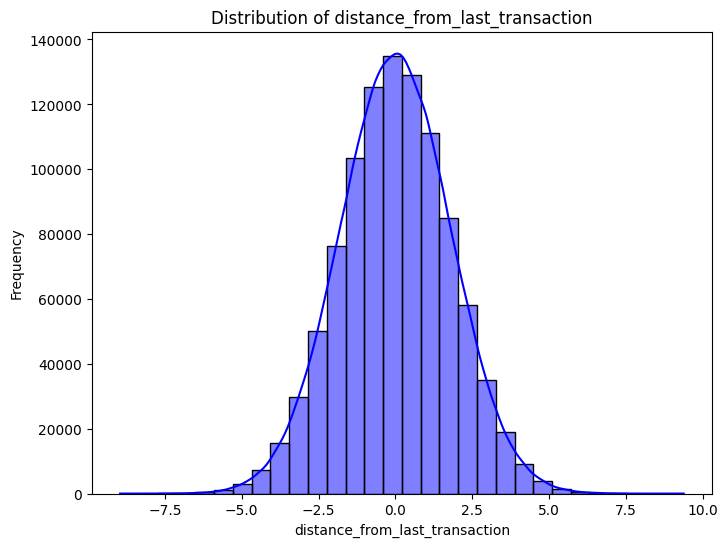

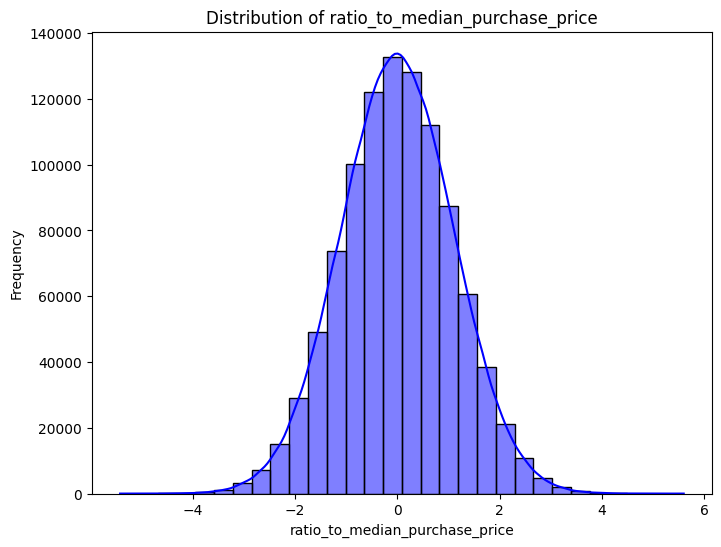

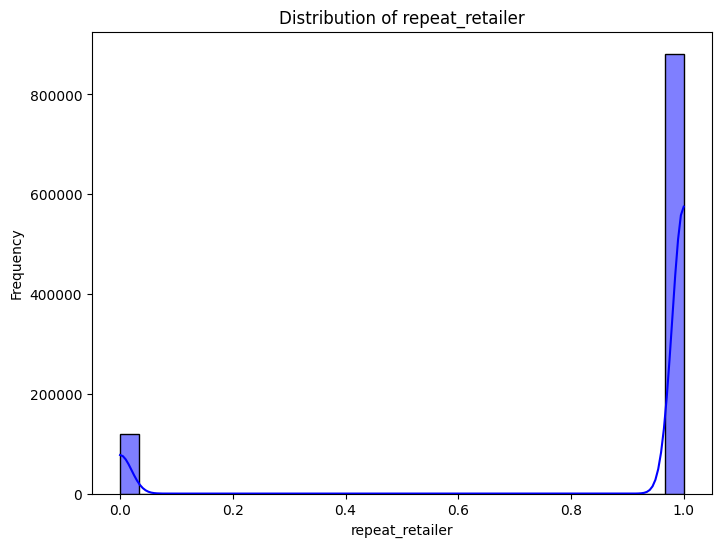

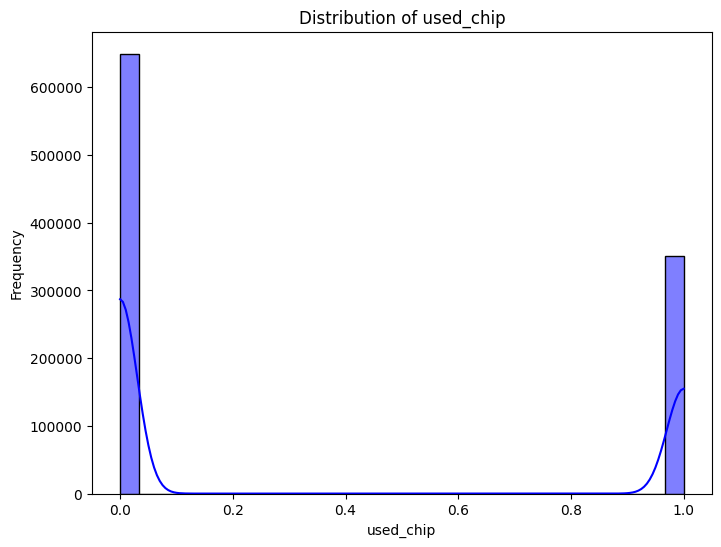

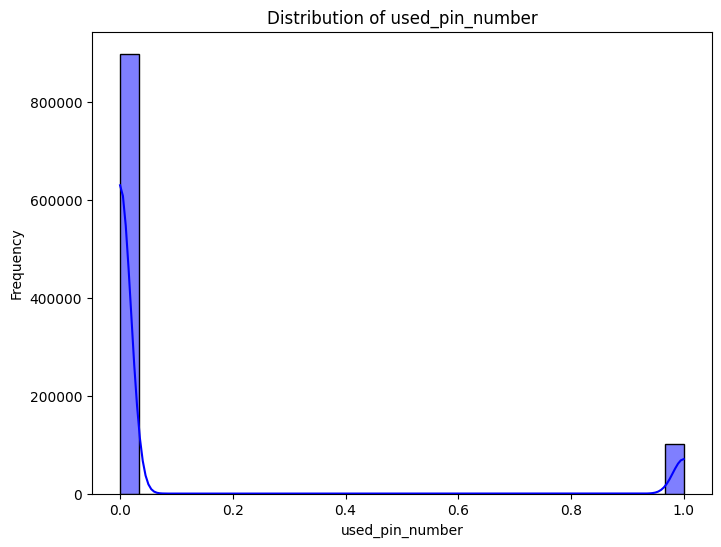

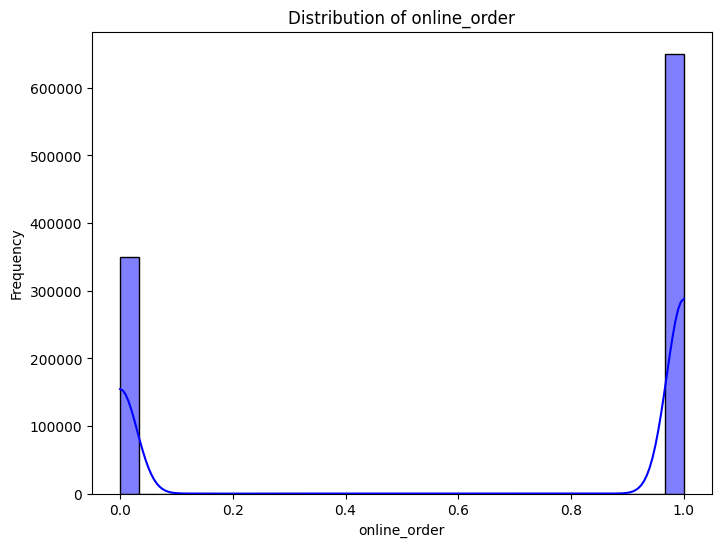

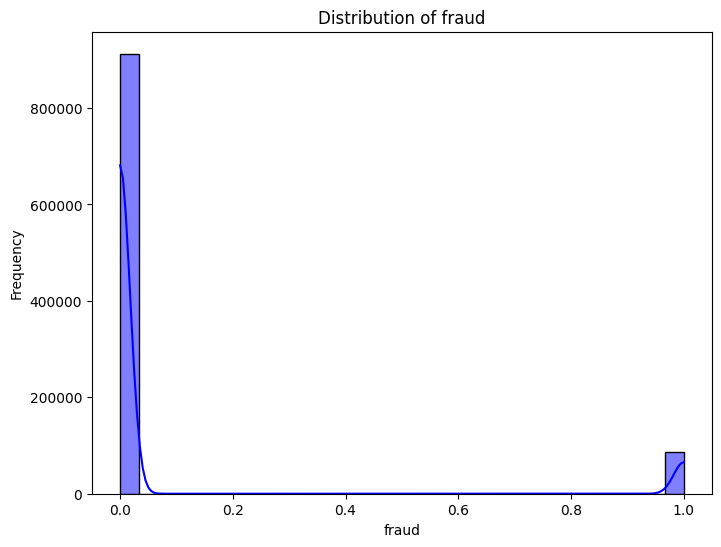

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew

# Plot distribution for all columns
for column in df.columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(df[column], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

<ipython-input-28-669482483309>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
<ipython-input-28-669482483309>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[col])
<ipython-input-28-669482483309>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn

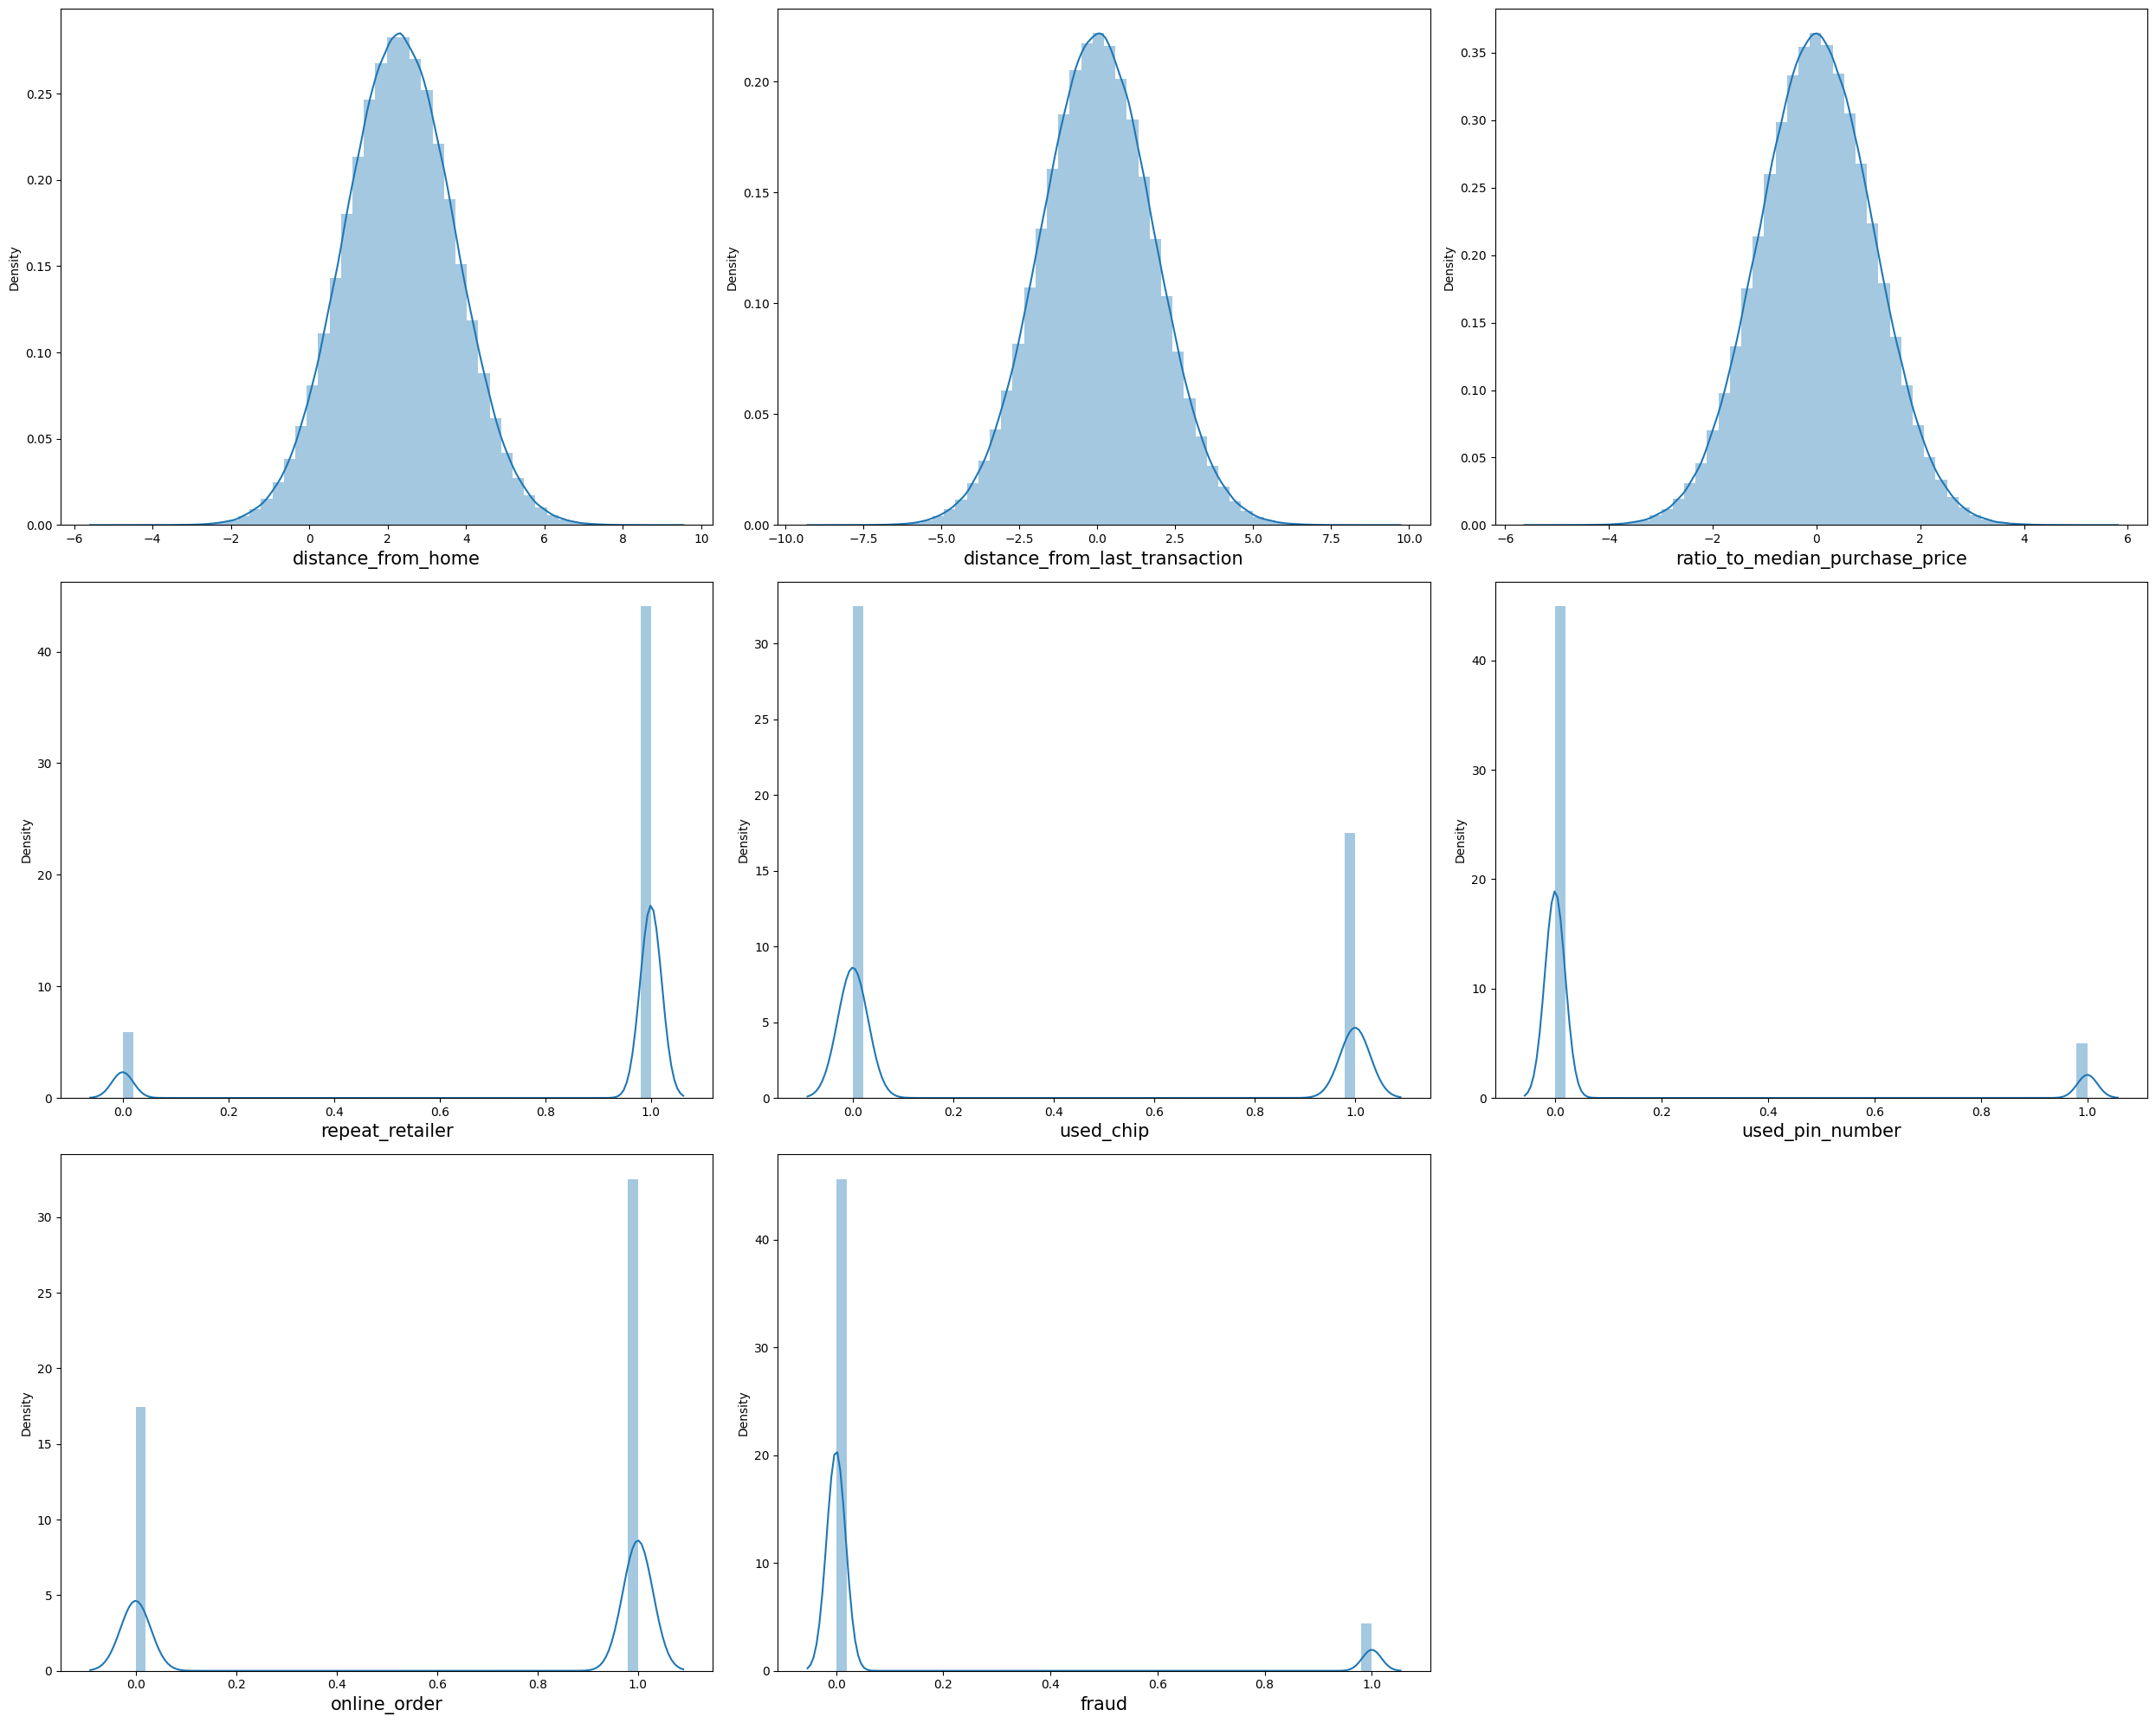

In [28]:
# Distribution Plot
plt.figure(figsize = (25, 20))
plotnumber = 1

for col in df.columns:
    if plotnumber <= 9:
        ax = plt.subplot(3, 3, plotnumber)
        sns.distplot(df[col])
        plt.xlabel(col, fontsize = 15)

    plotnumber += 1

plt.tight_layout()
plt.show()

In [29]:
# Check skewness
column_skewness = skew(df[column].dropna())  # Dropping NaN values for skewness calculation
print(f"Skewness of {column}: {column_skewness}")

Skewness of fraud: 2.921819434106791


In [32]:
#!pip install ydata-profiling
from ydata_profiling import ProfileReport

In [33]:
# Create a ProfileReport
profile = ProfileReport(df, title="Sample Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

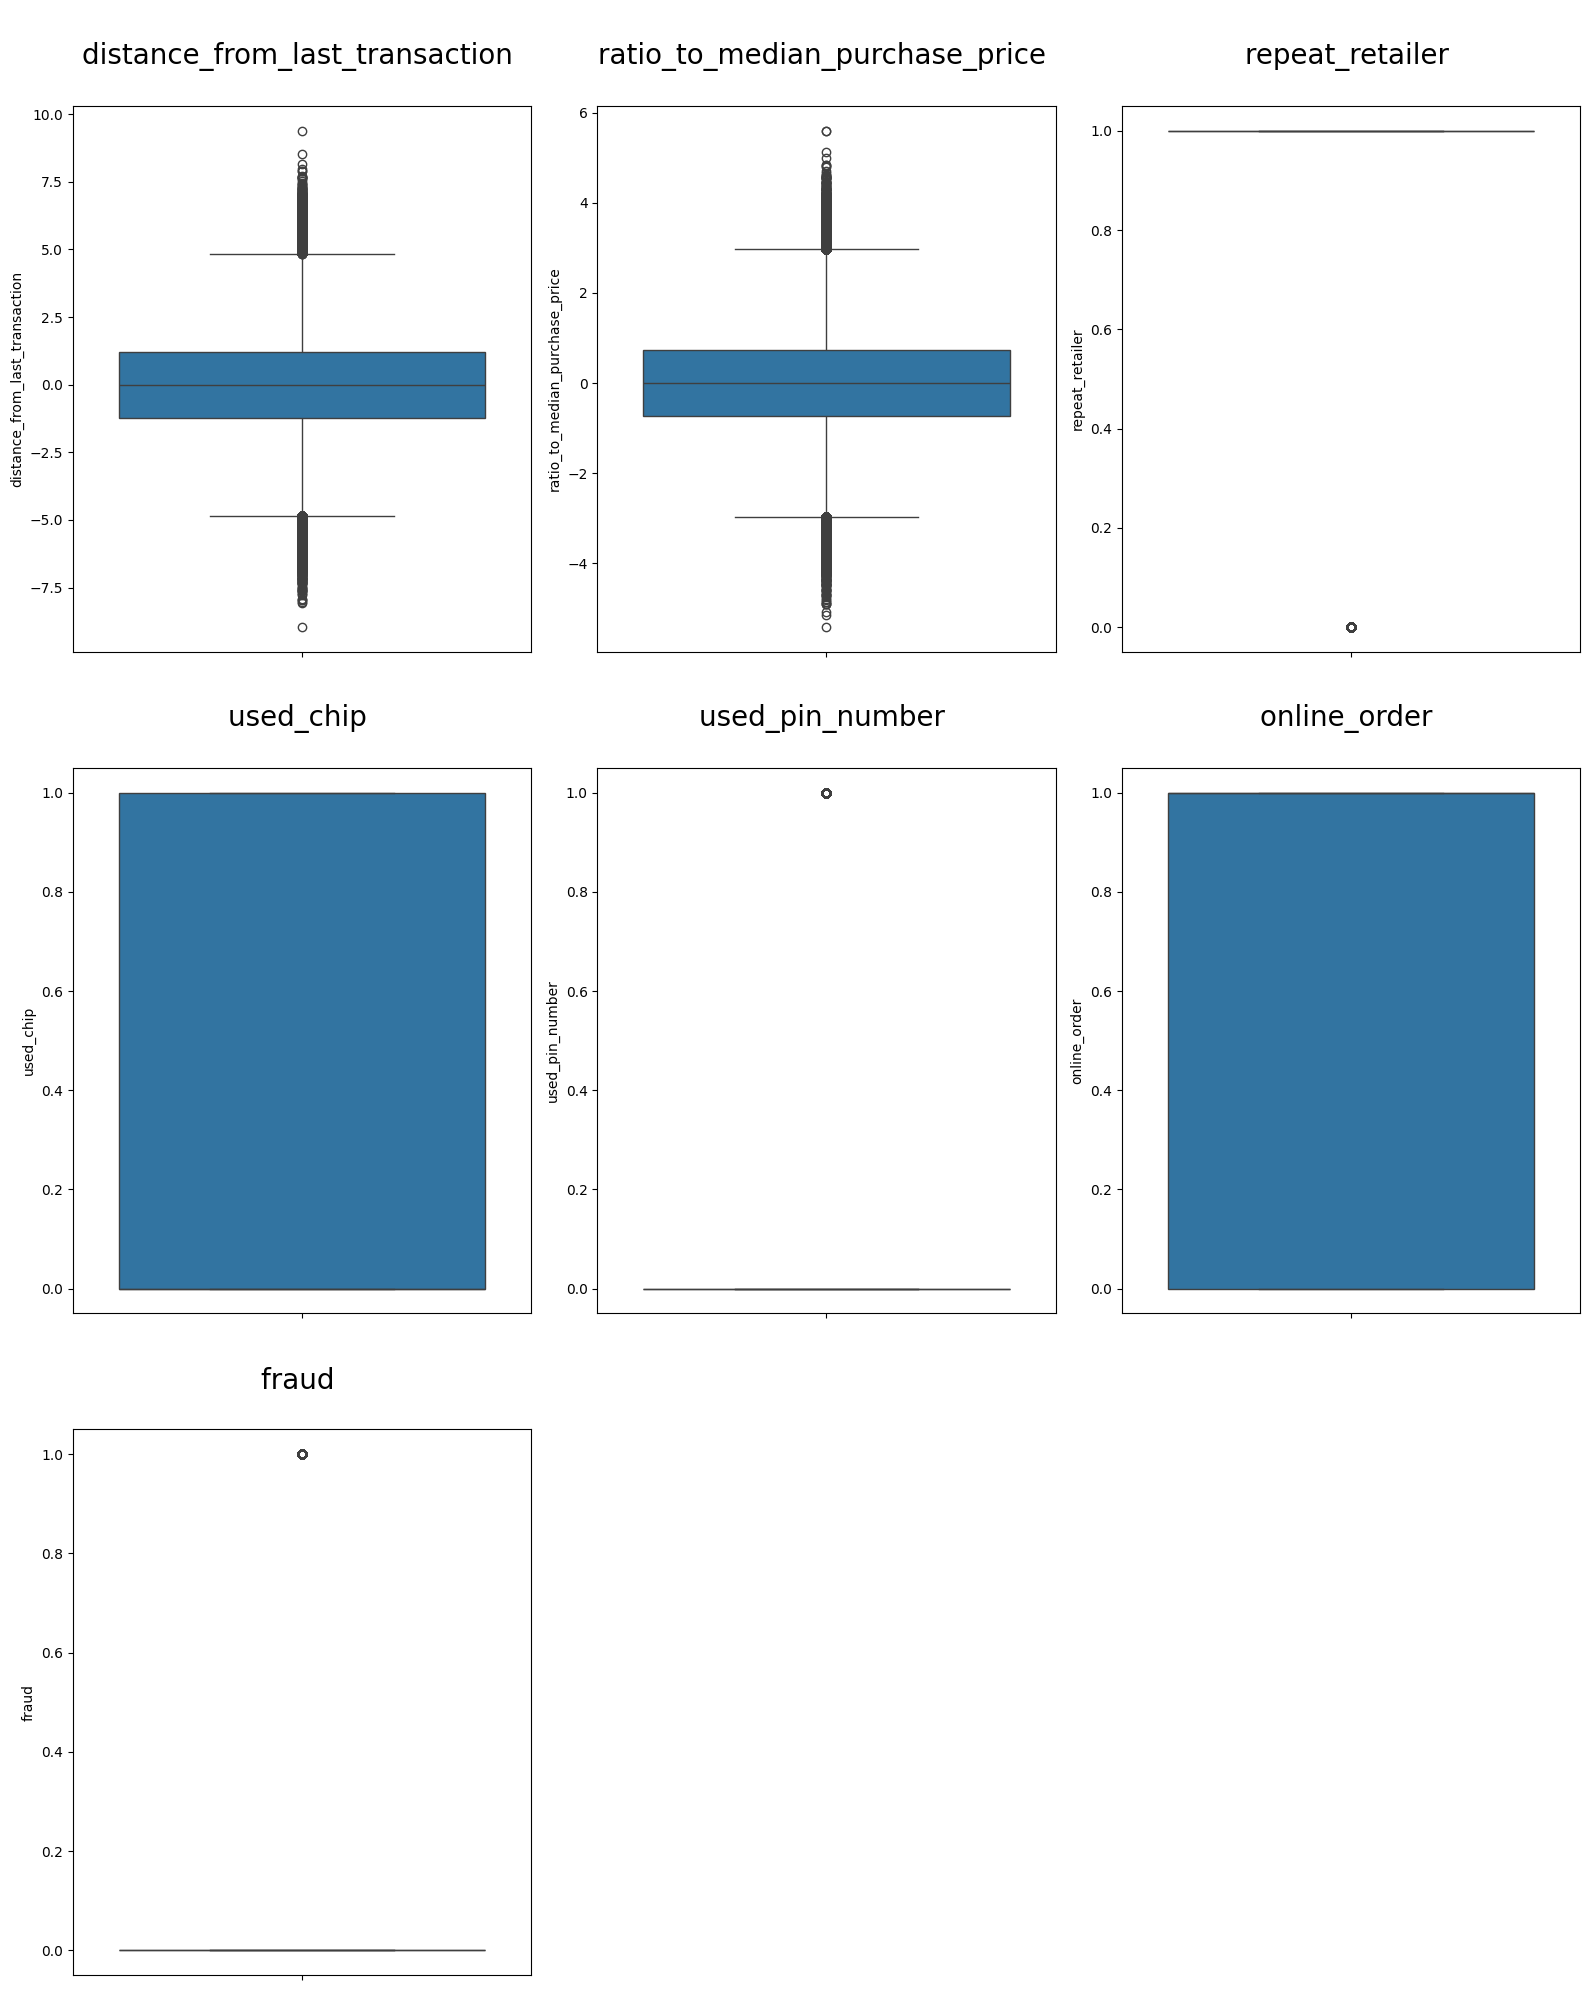

In [34]:
#Outlier detection
cols = df.columns

plt.figure(figsize = (16, 20))
plotnumber = 1

for i in range(1, len(cols)):
    if plotnumber <= 9:
        ax = plt.subplot(3, 3, plotnumber)
        sns.boxplot(y = cols[i], data = df, ax = ax)
        plt.title(f"\n{cols[i]} \n", fontsize = 20)

    plotnumber += 1

plt.tight_layout()
plt.show()

In [35]:

# Handle class imbalance using SMOTE
X = df.drop(columns=['fraud'])
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


Why Not Apply StandardScaler to Categorical Features?
Nature of Categorical Features:

Categorical features (e.g., 0 or 1) represent distinct categories, not continuous numerical values. Applying StandardScaler to these features doesn't make sense because scaling is intended to normalize continuous variables by centering them around their mean and scaling by their standard deviation.
For example, if repeat_retailer is binary (0 or 1), its mean will typically be close to 0 (if the column is imbalanced) or 0.5 (if balanced). Scaling this would result in non-binary values, which loses the categorical meaning.
Impact on Binary Features:

If you scale binary data, you will convert 0 and 1 to continuous values (e.g., -1.0, 1.0 after scaling), which might confuse models that expect binary indicators.
Machine Learning Models Handle Binary Data Well:

Most machine learning algorithms (e.g., Logistic Regression, Decision Trees, Random Forest, etc.) are designed to work with binary or categorical data as they are (encoded as 0 and 1).
Why Apply StandardScaler Only to Numerical Features?
Numerical features like distance_from_home, distance_from_last_transaction, and ratio_to_median_purchase_price often have wide ranges or skewed distributions. StandardScaler transforms these features to have:

Mean = 0
Standard Deviation = 1 This ensures that the features are on a similar scale, making it easier for models (especially distance-based or gradient-based models) to optimize.
What Should Be Done for Categorical Features?
Leave Binary Categorical Features As-Is:

If the features are already encoded as 0 and 1, no scaling is needed.
Optional Scaling for Specific Algorithms:

If you plan to use algorithms like SVM or KNN, where feature scaling might slightly help binary features, you can apply MinMaxScaler instead of StandardScaler. MinMaxScaler would keep binary data within 0 and 1, preserving their meaning.


In [36]:
# Apply StandardScaler to numerical features
scaler = StandardScaler()
numerical_features = ['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

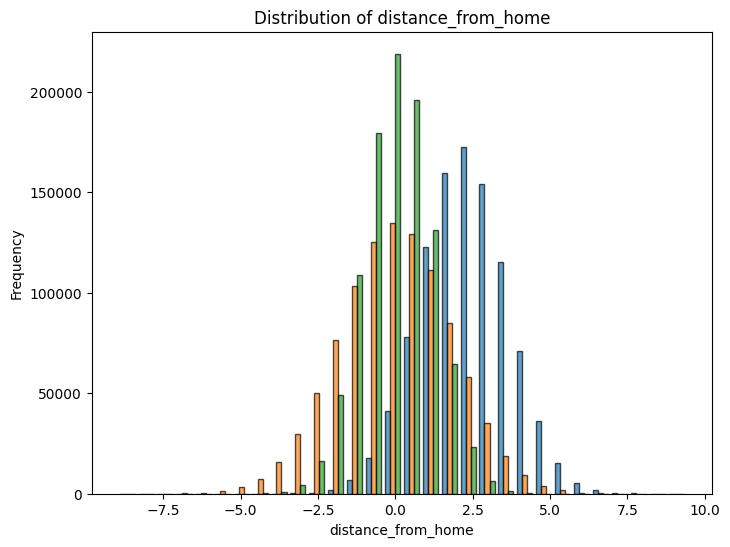

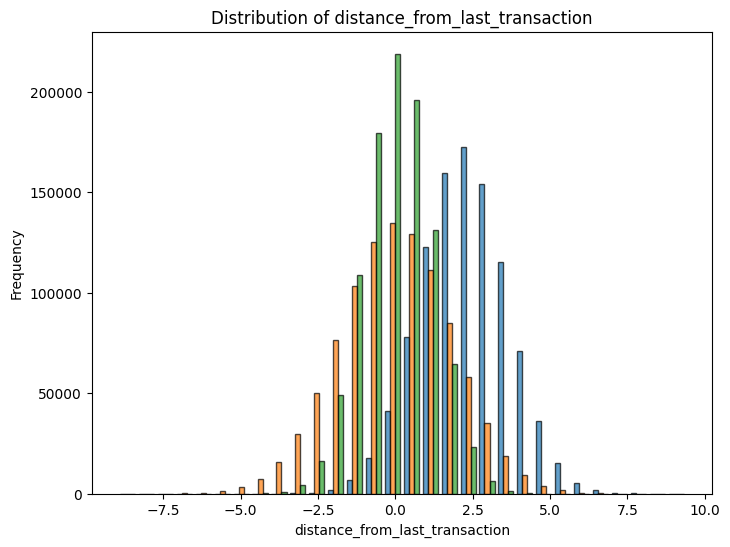

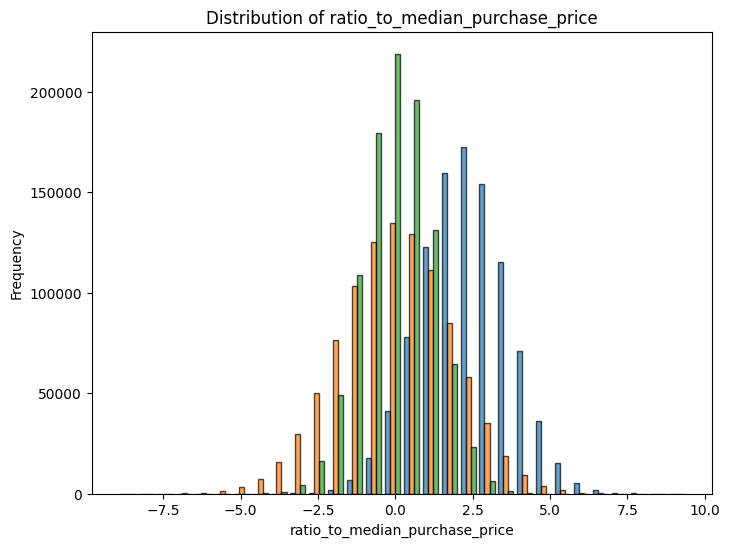

In [37]:
import matplotlib.pyplot as plt

# Plotting histograms for the standardized features
for feature in numerical_features:
    plt.figure(figsize=(8, 6))
    plt.hist(df[numerical_features], bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [38]:
# Oversampling minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


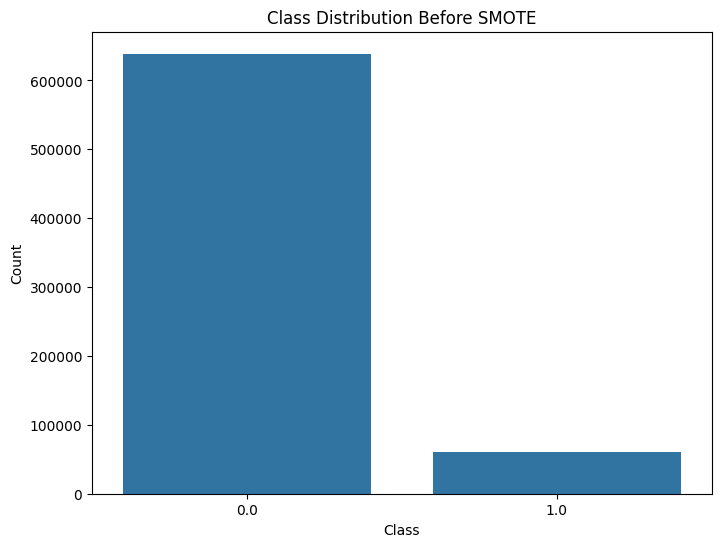

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting class distribution before SMOTE
plt.figure(figsize=(8,6))
sns.countplot(x=y_train)
plt.title("Class Distribution Before SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


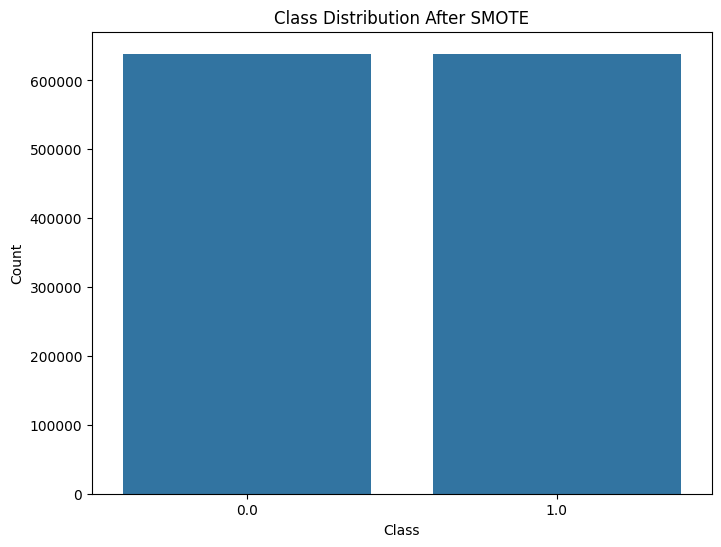

In [40]:
# Plotting class distribution after SMOTE (in y_train_resampled)
plt.figure(figsize=(8,6))
sns.countplot(x=y_train_resampled)
plt.title("Class Distribution After SMOTE")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


In [41]:
# Build and evaluate models
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
    }

In [42]:
for name, model in models.items():
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(X_test)
    print(f"\n{name} Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"ROC AUC Score: {roc_auc}")


Logistic Regression Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91    273779
         1.0       0.36      0.88      0.51     26221

    accuracy                           0.85    300000
   macro avg       0.67      0.87      0.71    300000
weighted avg       0.93      0.85      0.88    300000

Confusion Matrix:
 [[232430  41349]
 [  3048  23173]]
ROC AUC Score: 0.9420055874867943

Decision Tree Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    273779
         1.0       1.00      1.00      1.00     26221

    accuracy                           1.00    300000
   macro avg       1.00      1.00      1.00    300000
weighted avg       1.00      1.00      1.00    300000

Confusion Matrix:
 [[273765     14]
 [     2  26219]]
ROC AUC Score: 0.9999362945615154

Random Forest Classification Report:
              precision    recall  f1-score   supp

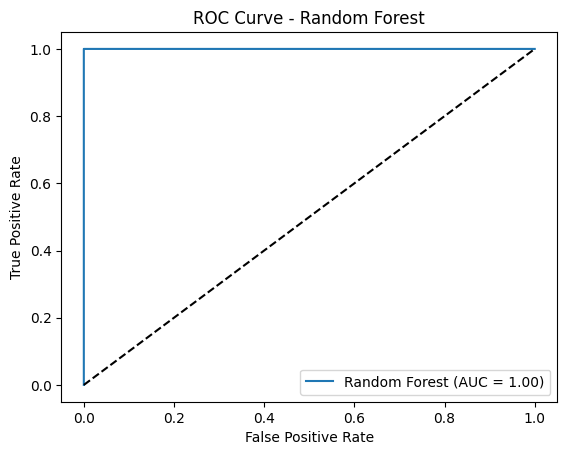

In [43]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve - {name}")
plt.legend(loc="lower right")
plt.show()

Classification Report will give you the precision, recall, and F1-score for both classes (fraud and non-fraud).
Confusion Matrix will show you how many frauds were correctly predicted (True Positives), how many were incorrectly predicted as non-fraud (False Negatives), etc.

ROC AUC Score will give you the area under the curve, which should be higher for a better model.

Choosing the Best Model
To select the best model:

Recall is usually more important than precision in fraud detection because you want to catch as many frauds as possible (minimize False Negatives).
F1-Score is a good metric to balance both recall and precision.
ROC-AUC score gives a good indication of the model's ability to distinguish between classes.
For fraud detection, typically you would prefer a model with high recall and a good balance between precision and recall (F1-Score). A high ROC-AUC score is also a good indicator of model performance.

After evaluating the metrics for each model, the one that has the highest recall or F1-Score (depending on your focus) is usually considered the best.

In [47]:
X_test.iloc[0].values

array([ 0.08079127, -1.49385236,  0.46255729,  1.        ,  0.        ,
        0.        ,  1.        ])

In [48]:
X_test.iloc[0].values.reshape(1,-1)

array([[ 0.08079127, -1.49385236,  0.46255729,  1.        ,  0.        ,
         0.        ,  1.        ]])

In [49]:
# Get the first row from X_test
single_sample = X_test.iloc[0].values.reshape(1, -1)  # Reshape to 2D array for model input


In [50]:
for name, model in models.items():
    probabilities = model.predict_proba(single_sample)
    print(f"{name} Predicted Probabilities for X_test[0]: {probabilities[0]}")


Logistic Regression Predicted Probabilities for X_test[0]: [0.64239048 0.35760952]
Decision Tree Predicted Probabilities for X_test[0]: [1. 0.]
Random Forest Predicted Probabilities for X_test[0]: [1. 0.]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [52]:
y_test.iloc[0]

0.0

In [53]:
# Get the first row as a DataFrame
single_sample = X_test.iloc[[0]]  # Double brackets to ensure it's a DataFrame

# Make predictions using the trained models
for name, model in models.items():
    probabilities = model.predict_proba(single_sample)
    print(f"{name} Predicted Probabilities for X_test[0]: {probabilities[0]}")


Logistic Regression Predicted Probabilities for X_test[0]: [0.64239048 0.35760952]
Decision Tree Predicted Probabilities for X_test[0]: [1. 0.]
Random Forest Predicted Probabilities for X_test[0]: [1. 0.]


1. Key Metrics and Definitions

Confusion Matrix
The confusion matrix provides a summary of the prediction results on a classification problem:

True Positives (TP): Cases where the model correctly predicts the positive class (1 in this case).

True Negatives (TN): Cases where the model correctly predicts the negative class (0 in this case).

False Positives (FP): Cases where the model predicts the positive class but the actual class is negative (0 predicted as 1).

False Negatives (FN): Cases where the model predicts the negative class but the actual class is positive (1 predicted as 0).

Metrics Explained

Precision: Out of all predicted positives, how many are actually positive?
Precision
=
𝑇
𝑃/
𝑇
𝑃
+
𝐹
𝑃
Precision=
TP+FP
TP
​

Recall (Sensitivity): Out of all actual positives, how many did the model correctly predict?
Recall
=
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑁
Recall=
TP+FN
TP
​

F1-score: Harmonic mean of precision and recall. It balances the two.
𝐹
1
=
2
⋅
Precision
⋅
Recall
Precision
+
Recall
F1=2⋅
Precision+Recall
Precision⋅Recall
​

Accuracy: Percentage of all correct predictions (TP + TN) out of total predictions.
Accuracy
=
𝑇
𝑃
+
𝑇
𝑁
Total Samples
Accuracy=
Total Samples
TP+TN
​

ROC AUC Score: Measures how well the model separates classes. A score closer to 1.0 indicates a better model.

2. Logistic Regression Breakdown
Confusion Matrix
[
TN (232430)
FP (41349)
FN (3048)
TP (23173)
]
[
TN (232430)
FN (3048)
​
  
FP (41349)
TP (23173)
​
 ]

TN (232430): Model correctly predicted class 0.
FP (41349): Model incorrectly predicted 1 when it was actually 0.
FN (3048): Model incorrectly predicted 0 when it was actually 1.
TP (23173): Model correctly predicted class 1.
Metrics:
Precision (Class 1):
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑃
=
23173
23173
+
41349
=
0.36
TP+FP
TP
​
 =
23173+41349
23173
​
 =0.36
Recall (Class 1):
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑁
=
23173
23173
+
3048
=
0.88
TP+FN
TP
​
 =
23173+3048
23173
​
 =0.88
F1-score (Class 1): Balances precision and recall:
2
⋅
0.36
⋅
0.88
0.36
+
0.88
=
0.51
2⋅
0.36+0.88
0.36⋅0.88
​
 =0.51.
Accuracy:
𝑇
𝑁
+
𝑇
𝑃
Total
=
232430
+
23173
300000
=
0.85
Total
TN+TP
​
 =
300000
232430+23173
​
 =0.85.
ROC AUC:
0.942
0.942: Good discrimination ability between classes.
Interpretation:
High recall for class 1 means the model identifies most fraudulent transactions.
Low precision for class 1 means there are many false positives (normal transactions incorrectly flagged as fraudulent).
3. Decision Tree Breakdown
Confusion Matrix
[
TN (273765)
FP (14)
FN (2)
TP (26219)
]
[
TN (273765)
FN (2)
​
  
FP (14)
TP (26219)
​
 ]
Almost perfect classification: very few FPs and FNs.
Metrics:
Precision:
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑃
=
26219
26219
+
14
=
1.00
TP+FP
TP
​
 =
26219+14
26219
​
 =1.00.
Recall:
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑁
=
26219
26219
+
2
=
1.00
TP+FN
TP
​
 =
26219+2
26219
​
 =1.00.
F1-score: Perfect at 1.00.
Accuracy:
273765
+
26219
300000
=
1.00
300000
273765+26219
​
 =1.00.
ROC AUC:
0.9999
0.9999: Almost perfect discrimination ability.
Interpretation:
The Decision Tree performs exceptionally well, possibly due to overfitting (memorizing the training data).
4. Random Forest Breakdown
Confusion Matrix
[
TN (273779)
FP (0)
FN (4)
TP (26217)
]
[
TN (273779)
FN (4)
​
  
FP (0)
TP (26217)
​
 ]
Near-perfect classification, similar to the Decision Tree.
Metrics:
Precision:
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑃
=
26217
26217
+
0
=
1.00
TP+FP
TP
​
 =
26217+0
26217
​
 =1.00.
Recall:
𝑇
𝑃
𝑇
𝑃
+
𝐹
𝑁
=
26217
26217
+
4
=
1.00
TP+FN
TP
​
 =
26217+4
26217
​
 =1.00.
F1-score:
1.00
1.00.
Accuracy:
1.00
1.00.
ROC AUC:
0.9999999
0.9999999.


Interpretation:
Random Forest slightly edges out the Decision Tree in stability, but both are nearly identical.


5. Which Model to Choose?
Logistic Regression:

Suitable for a balanced trade-off between precision and recall.
Recommended if interpretability is important.
Struggles with identifying class 1 (fraud) correctly.
Decision Tree:

High accuracy but likely overfits, especially on imbalanced data.
Not recommended unless the dataset is small or very structured.
Random Forest:

Best performance (accuracy, precision, recall, F1-score, ROC AUC).
Handles imbalance better than Decision Tree.
Recommended for production use, especially for imbalanced datasets.

Summary
Use Random Forest for the best overall performance.
Logistic Regression can serve as a benchmark model.
Be cautious of overfitting in Decision Tree and Random Forest; validate these models on unseen data.

In [55]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

In [102]:
# Define models and their hyperparameter grids for tuning
model_params = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000),
        "params": {
            "C": [0.1,10],
            "solver": ["liblinear", "lbfgs"]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeClassifier(),
        "params": {
            "max_depth": [5, 10],
            "min_samples_split": [2, 5]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(),
        "params": {
            "n_estimators": [10],
            "max_depth": [5],
            "min_samples_split": [2]
        }
    },
    "Gradient Boosting": {
        "model": GradientBoostingClassifier(),
        "params": {
            "n_estimators": [50],
            "learning_rate": [0.01],
            "max_depth": [3]
        }
    },
    "SVM": {
        "model": SVC(probability=True),
        "params": {
            "C": [0.1],
            "kernel": ["linear"]
        }
    },
    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [3],
            "weights": ["uniform", "distance"]
        }
    }
}


In [103]:
# Dictionary to store results
best_models = {}
evaluation_results = {}

In [104]:
model_params.items()

dict_items([('Logistic Regression', {'model': LogisticRegression(max_iter=1000), 'params': {'C': [0.1, 10], 'solver': ['liblinear', 'lbfgs']}}), ('Decision Tree', {'model': DecisionTreeClassifier(), 'params': {'max_depth': [5, 10], 'min_samples_split': [2, 5]}}), ('Random Forest', {'model': RandomForestClassifier(), 'params': {'n_estimators': [10], 'max_depth': [5], 'min_samples_split': [2]}}), ('Gradient Boosting', {'model': GradientBoostingClassifier(), 'params': {'n_estimators': [50], 'learning_rate': [0.01], 'max_depth': [3]}}), ('SVM', {'model': SVC(probability=True), 'params': {'C': [0.1], 'kernel': ['linear']}}), ('K-Nearest Neighbors', {'model': KNeighborsClassifier(), 'params': {'n_neighbors': [3], 'weights': ['uniform', 'distance']}})])

In [105]:
model_params.values()

dict_values([{'model': LogisticRegression(max_iter=1000), 'params': {'C': [0.1, 10], 'solver': ['liblinear', 'lbfgs']}}, {'model': DecisionTreeClassifier(), 'params': {'max_depth': [5, 10], 'min_samples_split': [2, 5]}}, {'model': RandomForestClassifier(), 'params': {'n_estimators': [10], 'max_depth': [5], 'min_samples_split': [2]}}, {'model': GradientBoostingClassifier(), 'params': {'n_estimators': [50], 'learning_rate': [0.01], 'max_depth': [3]}}, {'model': SVC(probability=True), 'params': {'C': [0.1], 'kernel': ['linear']}}, {'model': KNeighborsClassifier(), 'params': {'n_neighbors': [3], 'weights': ['uniform', 'distance']}}])

In [106]:
model_params.keys()

dict_keys(['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVM', 'K-Nearest Neighbors'])

In [107]:
for model_name, model_details in model_params.items():
    print(f"Starting GridSearch for {model_name}...")
    print(model_details["model"])
    print(model_details["params"])

Starting GridSearch for Logistic Regression...
LogisticRegression(max_iter=1000)
{'C': [0.1, 10], 'solver': ['liblinear', 'lbfgs']}
Starting GridSearch for Decision Tree...
DecisionTreeClassifier()
{'max_depth': [5, 10], 'min_samples_split': [2, 5]}
Starting GridSearch for Random Forest...
RandomForestClassifier()
{'n_estimators': [10], 'max_depth': [5], 'min_samples_split': [2]}
Starting GridSearch for Gradient Boosting...
GradientBoostingClassifier()
{'n_estimators': [50], 'learning_rate': [0.01], 'max_depth': [3]}
Starting GridSearch for SVM...
SVC(probability=True)
{'C': [0.1], 'kernel': ['linear']}
Starting GridSearch for K-Nearest Neighbors...
KNeighborsClassifier()
{'n_neighbors': [3], 'weights': ['uniform', 'distance']}


In [ ]:
# Perform hyperparameter tuning
for model_name, model_details in model_params.items():
    print(f"Starting GridSearch for {model_name}...")
    grid_search = GridSearchCV(
        model_details["model"],
        model_details["params"],
        scoring="roc_auc",
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best params for {model_name}: {grid_search.best_params_}")

Starting GridSearch for Logistic Regression...
Best params for Logistic Regression: {'C': 0.1, 'solver': 'lbfgs'}
Starting GridSearch for Decision Tree...


In [ ]:
# Evaluate all tuned models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_proba)
    evaluation_results[model_name] = {
        "classification_report": report,
        "roc_auc": roc_auc
    }
    print(f"\nEvaluation for {model_name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc}")


In [ ]:
# Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# Identify the best model based on ROC AUC
best_model_name = max(evaluation_results, key=lambda x: evaluation_results[x]["roc_auc"])
print(f"\nBest Model: {best_model_name}")
print(f"Best ROC AUC Score: {evaluation_results[best_model_name]['roc_auc']}")